#Imports

In [1]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Parameters

In [67]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

batch_size = 64
log_interval = 16
epochs = 20
bottleneck_dim = 32
use_conv = True
plot_images = True
plot_losses = True
save_images = False

root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: /content


# Load data

## MNIST binary

In [0]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

## Quick, Draw!

In [0]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        print(data.shape)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample, label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    data_dir = "gdrive/My Drive/DTU/Semester 2"
    # categories = ['cat', 'dog', 'pig', 'toothbrush']
    categories = ['apple', 'banana']

    xpixels = 28
    ypixels = 28

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 8000  # number of training images from each category
    n_take_test = 1600   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [0]:
# LOAD BNARY MNIST
# x_train, x_valid, x_test = get_binmnist_datasets(root)

# train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
# test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

In [6]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/2] Reading category index 0: 'apple' (144722 images: take 8000 training, take 1600 test)
[2/2] Reading category index 1: 'banana' (307936 images: take 8000 training, take 1600 test)
(16000, 28, 28, 1)
(3200, 28, 28, 1)


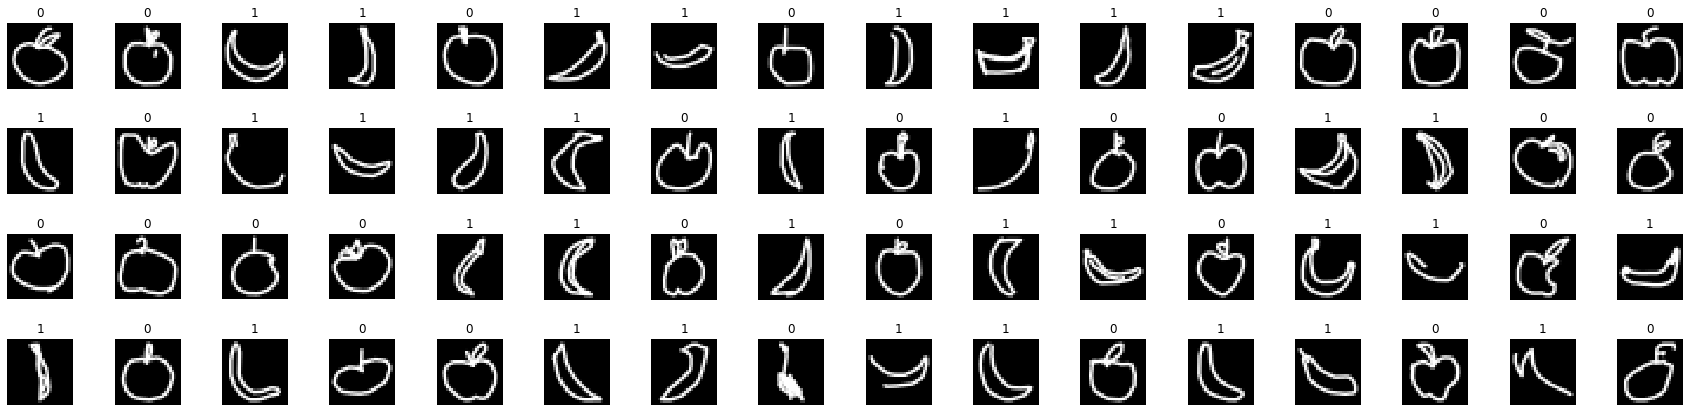

In [8]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

# VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Conv

In [0]:
ngf = 4
ndf = 4
nc = 1
h_dim=1024

class conv_VAE(nn.Module):
    def __init__(self, nz=32):
        super(conv_VAE, self).__init__()
        
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        # print("mu, logvar", mu.size(), logvar.size())
        z = self.reparametrize(mu, logvar)
        # print("z", z.size())
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar

# Loss function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()
    # return BCE + KLD, BCE, kl.mean()


# Train

In [0]:
def train(epoch):
    model.train()
    batch_loss, batch_kl = [],[]
    batch_idx = 0
    # batch_elbo = []

    for data, _ in train_loader:
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item() / len(data)) # divide by batch_size to get average
        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')   
        batch_idx = batch_idx + 1

    epoch_kl_train.append(np.mean(batch_kl))
    epoch_loss_train.append(np.mean(batch_loss))
    print(f'====> Epoch: {epoch} Average loss: {np.mean(batch_loss):.4f}')


# Test

In [0]:
def test(epoch):
    show_img = False
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    model.eval()
    batch_loss, batch_kl = [],[]
    
    with torch.no_grad():
        for data, _ in test_loader: 
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)

            batch_loss.append(loss.item() / len(data))
            batch_kl.append(kld.item())
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                plot_images(data, recon_batch, 32)
                show_img = False

    epoch_kl_test.append(np.mean(batch_kl))
    epoch_loss_test.append(np.mean(batch_loss))
    print(f'====> Test set loss: {np.mean(batch_loss):.4f}')

# Plots

In [65]:
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Plots the input, reconstructions, and latent space samples for 
def plot_images(data, recon_batch, bottleneck_dim):

    # Show input digits
    f, axarr = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axarr.flat):
        ax.imshow(data[i].cpu().view(28, 28), cmap="binary_r")
        ax.axis('off')
    plt.suptitle('Inputs')
    plt.show()

    # Show reconstructions
    f, axarr = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axarr.flat):
        ax.imshow(recon_batch[i].view(28, 28), cmap="binary_r")
        ax.axis('off')
    plt.suptitle('Reconstructions')
    plt.show()

    # Show latent space samples        
    with torch.no_grad():
        sample = torch.randn(64, bottleneck_dim).to(device)
        print(f'sample.shape {sample.shape}')
        sample = model.decode(sample).cpu()
        f, axarr = plt.subplots(8, 8, figsize=(8, 8))
        for i, ax in enumerate(axarr.flat):
            ax.imshow(sample[i].view(28, 28), cmap="binary_r")
            ax.axis('off')
        plt.suptitle('Latent space')
        plt.show()

    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    # inset_ax1 = inset_axes(ax1, height="100%", width="100%", loc=10) # center, you can check the different codes in plt.legend?
    # for 
    # inset_ax.plot(x, f, color='green')
    # inset_ax.set_xlim([0, 5])
    # inset_ax.set_ylim([0.75, 1.25])
    
    # fig = plt.figure(figsize=(3, 9))
    # outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)
    # gs = gridspec.GridSpec(4,2)
    # gs.update(hspace=0.4)

    # for i in range(3):
    #     # inner = gridspec.GridSpecFromSubplotSpec(8, 8,
    #     #                 subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    #     innner = outer_grid[i].subgridspec(8, 8, wspace=0.1, hspace=0.1)
    #     print(inner)
    #     # for j in range(2):
    #         # inputs
    #     # ax = plt.Subplot(fig, inner[0])
    #     for i, ax in range(64):
    #         ax = gif.add_subplot(inner[0])
    #         ax.imshow(data[i].cpu().view(28, 28), cmap="binary_r")
    #         ax.axis('off')
    #         ax.suptitle('Inputs')
    #     fig.add_subplot(ax)

    #     # reconstructions
    #     ax = plt.Subplot(fig, inner[1])
    #     for i, ax in enumerate(ax.flat):
    #         ax.imshow(recon_batch[i].view(28, 28), cmap="binary_r")
    #         ax.axis('off')
    #         ax.suptitle('Reconstructions')
    #     fig.add_subplot(ax)

    #     # latent space
    #     ax = plt.Subplot(fig, inner[2])
    #     sample = torch.randn(64, bottleneck_dim).to(device)
    #     print(f'sample.shape {sample.shape}')
    #     sample = model.decode(sample).cpu()
    #     f, axarr = plt.subplots(8, 8, figsize=(8, 8))
    #     for i, ax in enumerate(ax.flat):
    #         ax.imshow(sample[i].view(28, 28), cmap="binary_r")
    #         ax.axis('off')
    #         ax.suptitle('Latent samples')
    #     fig.add_subplot(ax)
    # fig.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def plot_losses(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    # ELBO loss
    ax1.set_title("ELBO loss")
    ax1.plot(epoch_list, train_loss_all, color="blue")
    ax1.plot(epoch_list, test_loss_all, color="green", linestyle="--")
    ax1.legend(['Training', 'Testing'])
    ax1.set(xlabel='epochs', ylabel='loss')

    # KL loss
    ax2.set_title("KL loss")
    ax2.plot(epoch_list, kl_loss_train, color="blue")
    ax2.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
    ax2.legend(['Training', 'Testing'])
    ax2.set(xlabel='epochs', ylabel='loss')
    
    plt.show()

# Main

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([64, 784])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


Train Epoch: 1 [0/16000 (0%)]	Loss: 599.759277
Train Epoch: 1 [1024/16000 (6%)]	Loss: 503.967621
Train Epoch: 1 [2048/16000 (13%)]	Loss: 452.616730
Train Epoch: 1 [3072/16000 (19%)]	Loss: 411.654480
Train Epoch: 1 [4096/16000 (26%)]	Loss: 377.569153
Train Epoch: 1 [5120/16000 (32%)]	Loss: 355.514587
Train Epoch: 1 [6144/16000 (38%)]	Loss: 335.308014
Train Epoch: 1 [7168/16000 (45%)]	Loss: 314.010986
Train Epoch: 1 [8192/16000 (51%)]	Loss: 304.319885
Train Epoch: 1 [9216/16000 (58%)]	Loss: 288.461426
Train Epoch: 1 [10240/16000 (64%)]	Loss: 277.286469
Train Epoch: 1 [11264/16000 (70%)]	Loss: 264.531555
Train Epoch: 1 [12288/16000 (77%)]	Loss: 258.384064
Train Epoch: 1 [13312/16000 (83%)]	Loss: 256.286255
Train Epoch: 1 [14336/16000 (90%)]	Loss: 248.764236
Train Epoch: 1 [15360/16000 (96%)]	Loss: 239.456924
====> Epoch: 1 Average loss: 333.3403
====> Test set loss: 240.6551
Train Epoch: 2 [0/16000 (0%)]	Loss: 236.869598
Train Epoch: 2 [1024/16000 (6%)]	Loss: 231.006348
Train Epoch: 2 [20

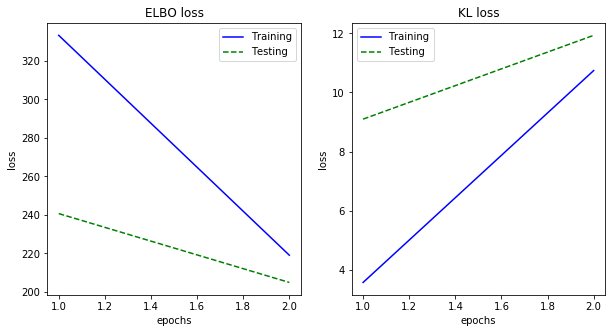

################################################################
Train Epoch: 3 [0/16000 (0%)]	Loss: 204.615479
Train Epoch: 3 [1024/16000 (6%)]	Loss: 196.767334
Train Epoch: 3 [2048/16000 (13%)]	Loss: 205.146896
Train Epoch: 3 [3072/16000 (19%)]	Loss: 193.121902
Train Epoch: 3 [4096/16000 (26%)]	Loss: 202.257843
Train Epoch: 3 [5120/16000 (32%)]	Loss: 193.185532
Train Epoch: 3 [6144/16000 (38%)]	Loss: 198.457031
Train Epoch: 3 [7168/16000 (45%)]	Loss: 197.856995
Train Epoch: 3 [8192/16000 (51%)]	Loss: 191.016586
Train Epoch: 3 [9216/16000 (58%)]	Loss: 189.761475
Train Epoch: 3 [10240/16000 (64%)]	Loss: 184.065063
Train Epoch: 3 [11264/16000 (70%)]	Loss: 191.265869
Train Epoch: 3 [12288/16000 (77%)]	Loss: 187.761185
Train Epoch: 3 [13312/16000 (83%)]	Loss: 182.285995
Train Epoch: 3 [14336/16000 (90%)]	Loss: 188.680496
Train Epoch: 3 [15360/16000 (96%)]	Loss: 197.145569
====> Epoch: 3 Average loss: 195.1868
====> Test set loss: 188.1503


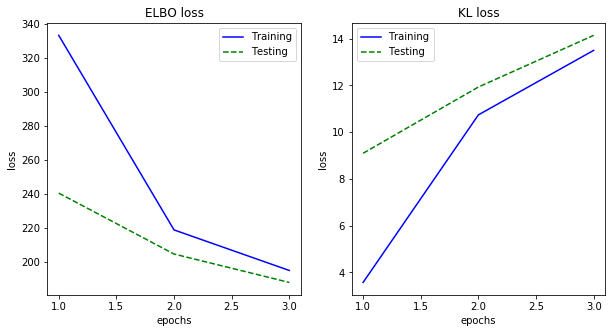

################################################################
Train Epoch: 4 [0/16000 (0%)]	Loss: 187.121780
Train Epoch: 4 [1024/16000 (6%)]	Loss: 177.513504
Train Epoch: 4 [2048/16000 (13%)]	Loss: 193.934464
Train Epoch: 4 [3072/16000 (19%)]	Loss: 179.484756
Train Epoch: 4 [4096/16000 (26%)]	Loss: 172.291824
Train Epoch: 4 [5120/16000 (32%)]	Loss: 183.149124
Train Epoch: 4 [6144/16000 (38%)]	Loss: 177.322098
Train Epoch: 4 [7168/16000 (45%)]	Loss: 185.771301
Train Epoch: 4 [8192/16000 (51%)]	Loss: 188.334702
Train Epoch: 4 [9216/16000 (58%)]	Loss: 181.583221
Train Epoch: 4 [10240/16000 (64%)]	Loss: 188.374969
Train Epoch: 4 [11264/16000 (70%)]	Loss: 185.718231
Train Epoch: 4 [12288/16000 (77%)]	Loss: 181.913651
Train Epoch: 4 [13312/16000 (83%)]	Loss: 182.038895
Train Epoch: 4 [14336/16000 (90%)]	Loss: 180.755859
Train Epoch: 4 [15360/16000 (96%)]	Loss: 179.166138
====> Epoch: 4 Average loss: 182.0455
====> Test set loss: 178.8217


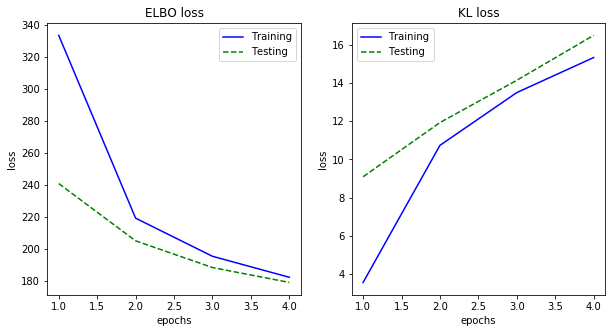

################################################################
Train Epoch: 5 [0/16000 (0%)]	Loss: 177.811920
Train Epoch: 5 [1024/16000 (6%)]	Loss: 175.396194
Train Epoch: 5 [2048/16000 (13%)]	Loss: 177.050781
Train Epoch: 5 [3072/16000 (19%)]	Loss: 182.075775
Train Epoch: 5 [4096/16000 (26%)]	Loss: 169.372025
Train Epoch: 5 [5120/16000 (32%)]	Loss: 176.653900
Train Epoch: 5 [6144/16000 (38%)]	Loss: 175.354523
Train Epoch: 5 [7168/16000 (45%)]	Loss: 179.206955
Train Epoch: 5 [8192/16000 (51%)]	Loss: 179.211487
Train Epoch: 5 [9216/16000 (58%)]	Loss: 172.814789
Train Epoch: 5 [10240/16000 (64%)]	Loss: 180.376129
Train Epoch: 5 [11264/16000 (70%)]	Loss: 171.480316
Train Epoch: 5 [12288/16000 (77%)]	Loss: 179.486099
Train Epoch: 5 [13312/16000 (83%)]	Loss: 172.853760
Train Epoch: 5 [14336/16000 (90%)]	Loss: 184.704285
Train Epoch: 5 [15360/16000 (96%)]	Loss: 165.208649
====> Epoch: 5 Average loss: 175.4667
====> Test set loss: 175.3208


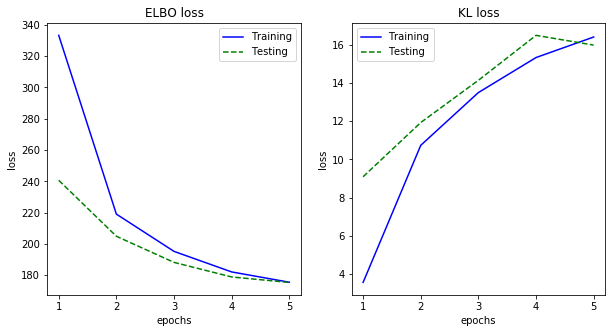

################################################################
Train Epoch: 6 [0/16000 (0%)]	Loss: 180.471252
Train Epoch: 6 [1024/16000 (6%)]	Loss: 173.682129
Train Epoch: 6 [2048/16000 (13%)]	Loss: 172.961945
Train Epoch: 6 [3072/16000 (19%)]	Loss: 171.700394
Train Epoch: 6 [4096/16000 (26%)]	Loss: 171.834900
Train Epoch: 6 [5120/16000 (32%)]	Loss: 183.149521
Train Epoch: 6 [6144/16000 (38%)]	Loss: 169.587952
Train Epoch: 6 [7168/16000 (45%)]	Loss: 174.034302
Train Epoch: 6 [8192/16000 (51%)]	Loss: 173.180466
Train Epoch: 6 [9216/16000 (58%)]	Loss: 174.521027
Train Epoch: 6 [10240/16000 (64%)]	Loss: 169.539566
Train Epoch: 6 [11264/16000 (70%)]	Loss: 162.862549
Train Epoch: 6 [12288/16000 (77%)]	Loss: 164.638855
Train Epoch: 6 [13312/16000 (83%)]	Loss: 162.481781
Train Epoch: 6 [14336/16000 (90%)]	Loss: 167.108307
Train Epoch: 6 [15360/16000 (96%)]	Loss: 170.886230
====> Epoch: 6 Average loss: 170.5671
====> Test set loss: 170.1389


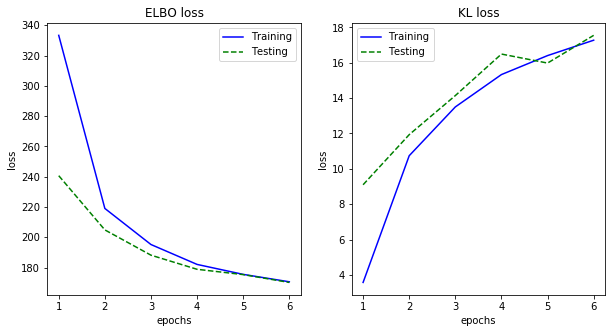

################################################################
Train Epoch: 7 [0/16000 (0%)]	Loss: 170.600159
Train Epoch: 7 [1024/16000 (6%)]	Loss: 167.071320
Train Epoch: 7 [2048/16000 (13%)]	Loss: 169.523468
Train Epoch: 7 [3072/16000 (19%)]	Loss: 170.836121


KeyboardInterrupt: ignored

In [66]:
model = conv_VAE().to(device) if use_conv else VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if __name__ == "__main__":

    epoch_list = []
    epoch_loss_train, epoch_kl_train = [], [] # Train losses per epoch (mean of batch losses)
    epoch_loss_test, epoch_kl_test = [], [] # Test losses per epoch (mean of batch losses)
    
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        
        epoch_list.append(epoch)
        if epoch == 1:
            continue

        plot_losses(epoch_list, epoch_loss_train, epoch_loss_test, epoch_kl_train, epoch_kl_test)
        print("################################################################")
            
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        #clear_output(wait=True)
